# Final Project - Evaporating Liquidity

#### Ruilong Guo, Sifei Zhao, Zhiyuan Liu, Junhan Fu

In this project, we replicate tables from the paper "_Evaporating Liquidity_" by Stefan Nagel using the Principals of Reproducible Analytical Pipelines (RAPs) learned in the class. 

The author demonstrates that short-term reversal strategy profits stem from liquidity provision, making them notably predictable by the VIX index. Additionally, the author discovered that these reversal strategies yield substantial returns not only for individual stocks but also for industry portfolios, particularly during high VIX periods.

Our replication is automated from end-to-end using Pydoit, formatted using the project template (blank_project) provided by professor Bejarano, which is based on the Cookiecutter Data Science template.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import config
import statsmodels.api as sm
import plotly.express as px

import load_CRSP_stock
import load_FF_industry
import load_vix

import clean_CRSP_stock
import calc_reversal_strategy
import additional_analysis
import regression
import regression_hac

DATA_DIR = config.DATA_DIR

import warnings
warnings.filterwarnings('ignore')


## Data Collection

### 1. Pull and load CRSP data from WRDS

Using `load_CRSP_stock`, we pull and save CRSP daily stock data and indexes from WRDS (Wharton Research Data Services). 

The CRSP daily stock data is needed to construct individual portfolios based on Reversal strategy. The CRSP daily index data is needed to evaluate the performance of Reversal strategy portfolios.

Specifically:
- we use query to pull data of stocks with share code 10 or 11, from NYSE, AMEX, and Nasdaq
- pull one extra month of daily stock data for later data cleaning and processing

#### 1) CRSP daily stock data

In [2]:
df_dsf = load_CRSP_stock.load_CRSP_daily_file(data_dir=DATA_DIR)
df_dsf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29892809 entries, 0 to 392808
Data columns (total 12 columns):
 #   Column   Dtype         
---  ------   -----         
 0   date     datetime64[ns]
 1   permno   int64         
 2   permco   int64         
 3   exchcd   int64         
 4   prc      float64       
 5   bid      float64       
 6   ask      float64       
 7   shrout   float64       
 8   cfacpr   float64       
 9   cfacshr  float64       
 10  ret      float64       
 11  retx     float64       
dtypes: datetime64[ns](1), float64(8), int64(3)
memory usage: 2.9 GB


#### 2) CRSP daily indexes

In [3]:
df_msix = load_CRSP_stock.load_CRSP_index_files(data_dir=DATA_DIR)
df_msix.columns

Index(['caldt', 'vwretd', 'vwindd', 'vwretx', 'vwindx', 'ewretd', 'ewindd',
       'ewretx', 'ewindx', 'sprtrn', 'spindx', 'decret1', 'decind1', 'decret2',
       'decind2', 'decret3', 'decind3', 'decret4', 'decind4', 'decret5',
       'decind5', 'decret6', 'decind6', 'decret7', 'decind7', 'decret8',
       'decind8', 'decret9', 'decind9', 'decret10', 'decind10', 'totval',
       'totcnt', 'usdval', 'usdcnt'],
      dtype='object')

### 2. Pull and load data from the Fama-French Data Library



Using `load_FF_industry`, we pull and save 48 industry portfolio daily returns from the Fama/French Data Library. 

The industry portfolios are constructed by classifying stocks into 48 industries as in Fama and French (1997). The industry portfolio daily returns are needed to construct the industry portfolios based on Reversal strategy.

In [4]:
ff = load_FF_industry.load_FF_industry_portfolio_daily(data_dir=DATA_DIR)

#### Average Value Weighted Daily Returns

In [5]:
ff[0].tail()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-22,0.52,0.74,0.65,0.48,0.12,-0.57,-0.45,0.36,0.52,-6.27,...,0.39,0.51,0.37,0.08,0.04,0.21,0.28,0.59,0.44,0.18
2023-12-26,0.99,0.63,0.82,0.58,0.20,0.99,0.63,0.63,0.44,-0.02,...,0.71,0.41,0.39,0.16,0.33,0.72,0.14,0.96,0.57,0.38
2023-12-27,-0.03,0.23,0.59,0.24,0.26,0.34,0.07,1.25,0.22,-0.32,...,0.36,-0.03,0.06,0.26,0.07,0.23,0.19,1.05,0.68,0.16
2023-12-28,0.29,0.52,0.00,0.14,0.20,-0.13,0.24,0.99,0.02,0.63,...,-0.35,0.10,-0.19,-0.03,0.10,0.33,0.41,-0.13,0.26,0.17
2023-12-29,-0.40,0.23,0.21,0.09,0.13,-1.11,-0.70,-0.09,0.23,-0.40,...,-0.87,-0.90,-0.05,-0.52,0.06,-0.59,0.20,-0.95,-0.68,-0.24


### 3. Pull and load VIX from the Fama-French Data Library


Using `load_vix`, we pull and save CBOE Volatility Index data from FRED. The data is used later in table replicatation.

In [6]:
vix = load_vix.load_vix(data_dir=DATA_DIR)

---

## Data Cleaning and Processing

### 1. Select the desired subsample of the data

#### 1) For reversal strategy based on transaction prices calculated from daily closing prices

1. Adjust prc with a negative sign to be positive

> Prc is the closing price or the negative bid/ask average for a trading day. If the closing price is not available on any given trading day, the number in the price field has a negative sign to indicate that it is a bid/ask average and not an actual closing price. Please note that in this field the negative sign is a symbol and that the value of the bid/ask average is not negative. If neither closing price nor bid/ask average is available on a date, prc is set to zero. 

2. Filter stocks with closing price (prc) of at least $1 on the last trading day of the previous calendar month

> To enter into the sample, a stock needs to have share code 10 or 11. In addition, it must have a closing price of at least $1 on the last trading day of the previous calendar month.


3. Select the CRSP stock data for a specific time period

In [7]:
def select_stocks_by_closing_prices(df):
    """
    Clean the CRSP stock data for strategy based on closing prices
    """

    # make sure 'prc' is positive (negative sign means using bid/ask average instead of closing price)
    df = clean_CRSP_stock.clean_prc_to_positive(df)

    # stocks must have a closing price of at least $1 on the last trading day of the previous calendar month
    df = clean_CRSP_stock.clean_1dollar_prc(df)

    # select time range of the data
    df = clean_CRSP_stock.clean_date(df, start_year=1998, end_year=2024)

    return df.reset_index()

#### 2) For reversal strategy based on quote-midpoints calculated from averages of closing bid and ask quotes

1. Adjust prc with a negative sign to be positive

2. Filter stocks with closing price (prc) of at least $1 on the last trading day of the previous calendar month

3. Select stocks traded on NASDAQ

4. Adjust bid and ask quotes for stock splits using CRSP adjustment factor

> Reversal strategy returns based on transaction prices are calculated from daily closing prices, and the reversal strategy returns based on quote-midpoints are calculated from averages of closing bid and ask quotes, as reported in the CRSP daily returns file (for Nasdaq stocks only), adjusted for stock splits and dividends using the CRSP adjustment factors and dividend information.


5. Filter stocks with ratio of bid to quote-midpoint not smaller than 0.5.

6. Filter stocks with one-day return based on quote-midpoints minus the return based on closing prices not less than -50% and not higher than 100%. If a closing transaction price is not available, the quote-midpoint is used to calculate transaction-price returns.

7. Select the CRSP stock data for a specific time period


> In a few instances, the closing bid and ask data for Nasdaq stocks on CRSP have some data recording errors, such as increases of bid or ask by a factor of 100 or digits that are cut off. 

> To screen out data recording errors of bid and ask data for Nasdaq stocks: require that the ratio of bid to quote-midpoint is not smaller than 0.5, and the one-day return based on quote-midpoints minus the return based on closing prices is not less than -50% and not higher than 100%. If a closing transaction price is not available, the quote-midpoint is used to calculate transaction-price returns.


In [8]:
def select_stocks_by_quote_midpoints(df):
    """
    Clean the CRSP stock data for strategy based on quote-midpoints
    """

    # make sure 'prc' is positive (negative sign means using bid/ask average instead of closing price)
    df = clean_CRSP_stock.clean_prc_to_positive(df)

    # Nasdaq stocks only
    df = df[df['exchcd'] == 3]

    # adjusting the price using adjustment factors
    df['bid'] = df['bid'] / df['cfacpr']
    df['ask'] = df['ask'] / df['cfacpr']
    df['quote_midpoint'] = (df['bid'] + df['ask']) / 2

    # ratio of bid to quote-midpoint is not smaller than 0.5
    df = clean_CRSP_stock.clean_bid_quote_midpoint(df)

    # one-day return based on quote-midpoints minus the return based on closing prices is less than -50% and higher than 100%
    df = clean_CRSP_stock.clean_one_day_return(df)

    # stocks must have a closing price of at least $1 on the last trading day of the previous calendar month
    df = clean_CRSP_stock.clean_1dollar_prc(df)

    # select time range of the data
    df = clean_CRSP_stock.clean_date(df, start_year=1998, end_year=2024)

    return df.reset_index()

### 2. Load cleaned data

In [9]:
dfcp = clean_CRSP_stock.load_CRSP_closing_price(data_dir=DATA_DIR)
dfcp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28450247 entries, 0 to 28450246
Data columns (total 13 columns):
 #   Column   Dtype         
---  ------   -----         
 0   index    int64         
 1   date     datetime64[ns]
 2   permno   int64         
 3   permco   int64         
 4   exchcd   int64         
 5   prc      float64       
 6   bid      float64       
 7   ask      float64       
 8   shrout   float64       
 9   cfacpr   float64       
 10  cfacshr  float64       
 11  ret      float64       
 12  retx     float64       
dtypes: datetime64[ns](1), float64(8), int64(4)
memory usage: 2.8 GB


In [10]:
dfmid = clean_CRSP_stock.load_CRSP_midpoint(data_dir=DATA_DIR)
dfmid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17426065 entries, 0 to 17426064
Data columns (total 16 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   index                     int64         
 1   date                      datetime64[ns]
 2   permno                    int64         
 3   permco                    int64         
 4   exchcd                    int64         
 5   prc                       float64       
 6   bid                       float64       
 7   ask                       float64       
 8   shrout                    float64       
 9   cfacpr                    float64       
 10  cfacshr                   float64       
 11  ret                       float64       
 12  retx                      float64       
 13  quote_midpoint            float64       
 14  transaction_price_return  float64       
 15  quote_midpoint_return     float64       
dtypes: datetime64[ns](1), float64(11), int64(4)
memory u

---

## Reversal Strategy 

### 1. Construct Reversal Strategy 

Each day t, the reversal strategy returns are calculated as the average of returns from five reversal strategies that weight stocks proportional to the negative of market-adjusted returns on days t − 1, t − 2, ..., t − 5, with weights scaled to add up to $1 short and $1 long.

$$w_{it}^R = -\left( \frac{1}{2} \sum_{i=1}^{N} \left| R_{it-1} - R_{mt-1} \right| \right)^{-1} \left( R_{it-1} - R_{mt-1} \right)$$

- $R_{mt-1} = \frac{1}{N}\sum_{i=1}^N R_{it-1}$: the equal-weighted market return.

In [11]:
def calc_reverse_strategy_ret(df, type_col='industry', ret_col='ret'):
    df = df.copy()
    df['ret-avg'] = df.groupby('date')[ret_col].transform(lambda x: x - x.mean())
    df['w'] = df.groupby('date')['ret-avg'].transform(lambda x: - x / (0.5 * x.abs().sum()))

    for i in range(1, 6):
        df[f'w_lag_{i}'] = df.groupby(type_col)['w'].shift(i)

    df['rev_ret'] = (df['w_lag_1'] + df['w_lag_2'] + df['w_lag_3'] + df['w_lag_4'] + df['w_lag_5']) * df[ret_col] / 5

    return df.groupby('date')['rev_ret'].sum()

To be specific, the returns of the reversal strategies are calculated as an overlay of the returns of five sub-strategies: One with portfolio weights conditioned on day t − 1 returns, one conditioned on day t − 2 data, ..., one conditioned on t − 5 data. Then we calculated the simple average of these five sub-strategies’ returns as the overall reversal strategy return.

### 2. Hedge against market factor risk

Besides, we constructed the hedged reversal strategies after eliminating time-varying market factor exposure and then calculated the returns.

We first estimated a regression

$$L^R_t = β_0 + β_1f_t + β_2 (f_t × sgn(f_{t−1})) + ε_t$$
- $f_t$ is the return on the CRSP value-weighted index
- $L^R_t$ is the reversal strategy return

The time-varying beta is $β_{t−1} = β_1 + β_2 sgn(f_{t−1})$. Then hedged returns are calculated as $L^R_t − β_{t−1}f_t$.

In [12]:
def calc_hedged_return(ret):
    
    index = load_CRSP_stock.load_CRSP_index_files(data_dir=DATA_DIR)
    index = index.set_index('caldt')['vwretx']*100
    shifted_sign = index.shift(1).apply(lambda x: 1 if x > 0 else -1)
    index_shifted_sign = index * shifted_sign

    factor = pd.concat([index, index_shifted_sign], axis=1)

    beta = calc_reversal_strategy.calc_multiple_beta(factor, ret)
    time_varying_beta = beta[0] + beta[1] * shifted_sign

    hedged_ret = ret - time_varying_beta * index

    return hedged_ret

---

## Table Replication

We replicate tables with data with time period from January 1998 to December 2010.

### __Table 1: Summary Statistics of Reversal Strategy Returns__

Panel A presents statistics for the raw returns of these strategies, while Panel B shows similar statistics for hedged returns, which are obtained by eliminating conditional market factor exposure.

#### Panel A. Raw returns

Reversal strategy returns are calculated both with transaction-price returns, quote-midpoint returns, and industry returns. In each case, the portfolio weights are calculated with the same type of return (on days t − 1 to t − 5) as the type used to calculate portfolio returns (on day t).

- Transaction-price returns are calculated from daily CRSP closing transaction prices (for NYSE, AMEX, and Nasdaq stocks). 
- Quote-midpoint returns are calculated from bid-ask midpoints of daily CRSP closing quotes (with Nasdaq stocks only). 
- The industry returns pulled from Fama and French are calculated with transaction prices. 

In [13]:
ret_raw = calc_reversal_strategy.load_reversal_return(data_dir=DATA_DIR)
ret_raw.describe()

,Transact. prices,Quote-midpoints,Industry portfolio
count,3271.000000,3271.000000,3271.000000
mean,0.305433,0.190251,0.015948
std,0.563410,0.666002,0.557583
min,-3.841128,-4.536907,-3.699509
25%,0.030626,-0.088126,-0.222983
50%,0.238444,0.136898,0.000405
75%,0.496925,0.395883,0.220673
max,9.819708,10.727361,4.925304


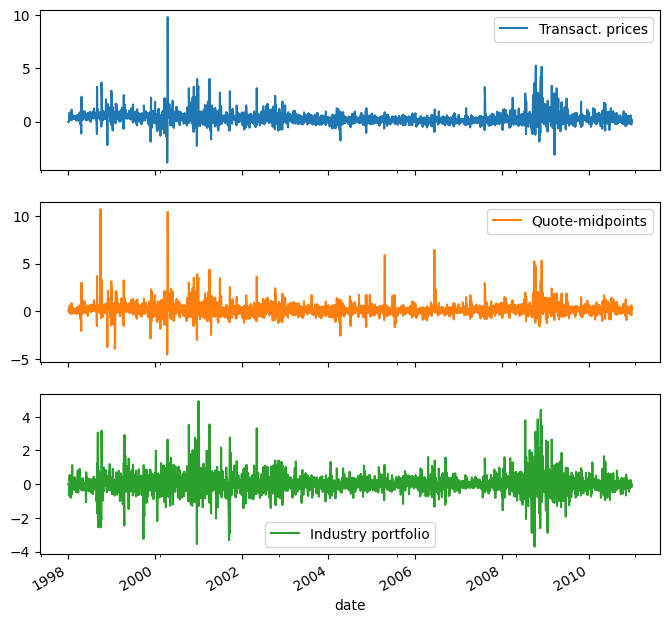

In [14]:
ret_raw.plot(subplots=True, figsize=(8, 8));

#### Replication of Table 1A

In [15]:
df_stat_A = calc_reversal_strategy.summary_stats(ret_raw)
df_stat_A


,Transact. prices,Quote-midpoints,Industry portfolio
Mean return(% per day),0.31,0.19,0.02
Std.dev.(% per day),0.56,0.67,0.56
Skewness,3.01,3.57,0.77
Kurtosis,38.46,50.15,14.60
Worst day return(%),-3.84,-4.54,-3.70
Worst 3-month return(%),2.51,-2.72,-12.17
Beta,0.11,0.09,0.10
Annualized Sharpe Ratio,8.61,4.53,0.45


#### Panel B. Returns hedged for conditional market

Also, we calculated the returns of hedged reversal strategies after eliminating time-varying market factor exposure.

In [16]:
ret_hedged = calc_reversal_strategy.load_reversal_return(data_dir=DATA_DIR, hedged=True)
ret_hedged.describe()

,Hedged Transact. prices,Hedged Quote-midpoints,Hedged Industry portfolio
count,3271.000000,3271.000000,3271.000000
mean,0.302422,0.187542,0.012924
std,0.541072,0.651498,0.535867
min,-3.052995,-3.957590,-3.311345
25%,0.028326,-0.102397,-0.236107
50%,0.238848,0.131694,-0.004331
75%,0.496864,0.404927,0.225650
max,9.606574,11.154354,4.153735


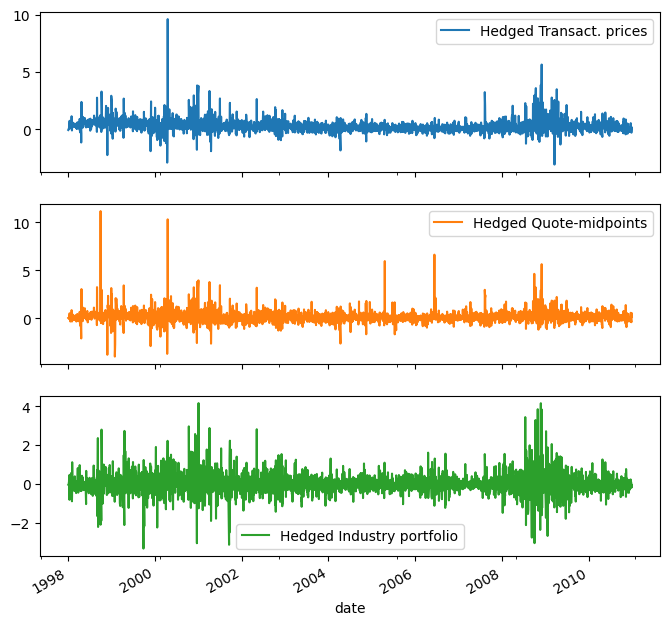

In [17]:
ret_hedged.plot(subplots=True, figsize=(8, 8));

#### Replication of Table 1B

In [18]:
df_stat_B = calc_reversal_strategy.summary_stats(ret_hedged)
df_stat_B

,Hedged Transact. prices,Hedged Quote-midpoints,Hedged Industry portfolio
Mean return(% per day),0.30,0.19,0.01
Std.dev.(% per day),0.54,0.65,0.54
Skewness,3.02,3.84,0.65
Kurtosis,39.00,55.84,12.20
Worst day return(%),-3.05,-3.96,-3.31
Worst 3-month return(%),2.07,-2.02,-9.18
Beta,0.00,0.00,0.00
Annualized Sharpe Ratio,8.87,4.57,0.38


### __Table 2: Predicting Reversal Strategy Returns with VIX__

As above, Table 2 is also replicated with data with time period from January 1998 to December 2010.

To replicate the prediction of returns from liquidity provision with VIX, we ran a regression of the form

$$ L^R_t =a+bVIX_t−5 +c'g_{t−5} +e_t$$

- $L^R_t$ is the reversal strategy return on day t.

- VIX is lagged by five days to account for the fact that the portfolio weights of the day t reversal strategy are conditioned on returns from days t − 1 to t − 5. In these regressions, the VIX is normalized to a daily volatility measure by dividing it by $\sqrt{250}$. 

- To control for effects of the institutional changes associated with decimalization, the control variable vector $g_{t−5}$ includes a dummy variable that takes a value of one prior to decimalization (April 9, 2001) and a value of zero thereafter. $R_M$ is also included in the control variable vector $g_{t−5}$, which is the lagged four-week return on the value-weighted CRSP index up until the end of day t − 5 to capture the dependence of reversal strategy profits on lagged market returns.

#### 1. Data preparation

$L^R_t$: Reversal strategy returns

In [19]:
reversal_ret = calc_reversal_strategy.load_reversal_return()
reversal_ret.columns = ['trade', 'quote', 'industry']

VIX: the CBOE S&P500 implied volatility index


In [20]:
vix = load_vix.load_vix()
vix.columns = ['VIX']

$R_M$: the lagged four-week return on the value-weighted CRSP index


In [21]:
rm = load_CRSP_stock.load_CRSP_index_files()
rm = rm.set_index('caldt')[['vwretx']]
rm.columns = ['$R_M$']

In the daily regressions, the dependent variable is the reversal strategy return on day t (in percent), and the predictor variables are measured at the end of day t − 5. 

In [22]:
data = regression_hac.prepare_data(reversal_ret, vix, rm)
data

,trade,quote,industry,VIX,$R_M$,Pre-decim.
date,,,,,,
1998-02-06,0.464865,0.222191,0.085646,1.357882,0.003725,1.0
1998-02-09,0.323731,0.160025,0.118470,1.350925,0.020183,1.0
1998-02-10,0.525014,0.252702,0.183127,1.307286,0.023125,1.0
1998-02-11,0.595980,0.397696,0.171833,1.299696,0.036387,1.0
1998-02-12,0.379299,0.038283,0.092732,1.346498,0.039314,1.0
...,...,...,...,...,...,...
2010-12-27,-0.268014,-0.376465,0.021103,1.018886,0.042154,0.0
2010-12-28,0.052037,-0.099845,-0.151843,1.037860,0.040183,0.0
2010-12-29,0.094361,0.576693,-0.166645,1.042919,0.047954,0.0


In the monthly regressions, the dependent variable is the monthly average of daily reversal strategy returns, and the predictor variables are measured five days before the end of the month preceding the return measurement month.

In [23]:
data_m = regression_hac.prepare_data(reversal_ret, vix, rm, to_monthly=True)
data_m

,trade,quote,industry,VIX,$R_M$,Pre-decim.
date,,,,,,
1998-03-31,0.363103,0.062443,-0.005563,1.201033,0.082434,1.0
1998-04-30,0.423615,0.148184,-0.006301,1.425555,0.055462,1.0
1998-05-31,0.548519,0.356511,-0.105370,1.389505,0.007566,1.0
1998-06-30,0.473279,0.168176,0.038785,1.201033,-0.006794,1.0
1998-07-31,0.545678,0.327329,-0.095268,1.266176,0.028733,1.0
...,...,...,...,...,...,...
2010-08-31,0.248619,0.266113,-0.088449,1.437571,0.032876,0.0
2010-09-30,0.212807,0.134503,-0.031441,1.688656,-0.044411,0.0
2010-10-31,0.145113,0.145868,-0.026048,1.373061,0.097271,0.0


#### 2. Regression with HAC standard errors


In [24]:
def regression_all(data, data_m, y_col):
    """
    Run regressions for 4 models
    """
    # VIX
    result_vix = regression_hac(data, y_col, ['VIX'])
    # VIX + g
    result_vix_g = regression_hac(data, y_col, ['VIX', 'Pre-decim.'])
    # VIX + g + RM
    result_vix_g_rm = regression_hac(data, y_col, ['VIX', 'Pre-decim.', '$R_M$'])
    # Monthly
    result_monthly = regression_hac(data_m, y_col, ['VIX', 'Pre-decim.', '$R_M$'], maxlags=3)
    
    return [result_vix, result_vix_g, result_vix_g_rm, result_monthly]

#### 3. Table 2 Replication

In [25]:
table = regression_hac.generate_table(data, data_m)
table

\makecell{Individual stocks\\Transaction-price returns}          \
                                                             Daily           
                                                               (1)     (2)   
Intercept                                               -0.06        -0.09   
                                                       (0.03)       (0.02)   
VIX                                                      0.25         0.23   
                                                       (0.02)       (0.02)   
Pre-decim.                                                            0.23   
                                                                    (0.03)   
$R_M$                                                                        
                                                                             
Adj. $R^2$                                               0.07         0.10   

                            \
                   Monthly   
               (3)     (4)   
Intercept    -0.06   -0.01   
            (0.03)  (0.02)   
VIX           0.21    0.18   
            (0.02)  (0.01)   
Pre-decim.    0.24    0.25   
            (0.03)  (0.03)   
$R_M$        -0.45    0.10   
            (0.19)  (0.23)   
Adj. $R^2$    0.10    0.65   

           \makecell{Individual stocks\\Quote-midpoint returns}          \
                                                          Daily           
                                                            (5)     (6)   
Intercept                                               -0.06     -0.08   
                                                       (0.03)    (0.03)   
VIX                                                      0.18      0.17   
                                                       (0.03)    (0.03)   
Pre-decim.                                                         0.10   
                                                                 (0.03)   
$R_M$                                                                     
                                                                          
Adj. $R^2$                                               0.02      0.03   

                           \makecell{Industry\\portfolios}                  \
                   Monthly                           Daily                   
               (7)     (8)                             (9)    (10)    (11)   
Intercept    -0.03    0.00                           -0.10   -0.10   -0.07   
            (0.04)  (0.03)                          (0.03)  (0.03)  (0.03)   
VIX           0.14    0.11                            0.08    0.08    0.06   
            (0.03)  (0.02)                          (0.02)  (0.02)  (0.02)   
Pre-decim.    0.11    0.12                                    0.01    0.01   
            (0.03)  (0.03)                                  (0.02)  (0.02)   
$R_M$        -0.79   -0.30                                           -0.57   
            (0.23)  (0.26)                                          (0.21)   
Adj. $R^2$    0.03    0.27                            0.01    0.01    0.01   

                    
           Monthly  
              (12)  
Intercept    -0.04  
            (0.02)  
VIX           0.04  
            (0.01)  
Pre-decim.    0.02  
            (0.02)  
$R_M$        -0.21  
            (0.16)  
Adj. $R^2$    0.07

Note: Newey-West HAC standard errors (with 20 lags for daily data and 3 lags for monthly data) are reported in parentheses.

---

## Table Reproduction

Here, we reproduce tables with updated data until December 2023.

### Table 1: Summary Statistics of Reversal Strategy Returns

#### Panel A. Raw returns

In [26]:
ret_raw_new = calc_reversal_strategy.load_reversal_return(data_dir=DATA_DIR, reproduce=True)
ret_raw_new.describe()

,Transact. prices,Quote-midpoints,Industry portfolio
count,6541.000000,6541.000000,6541.000000
mean,0.226815,0.159247,0.010462
std,0.668043,0.771905,0.517516
min,-12.435835,-7.490985,-3.699509
25%,-0.046301,-0.143267,-0.212210
50%,0.187188,0.121574,0.000655
75%,0.449608,0.406763,0.206637
max,9.819708,22.526910,4.925304


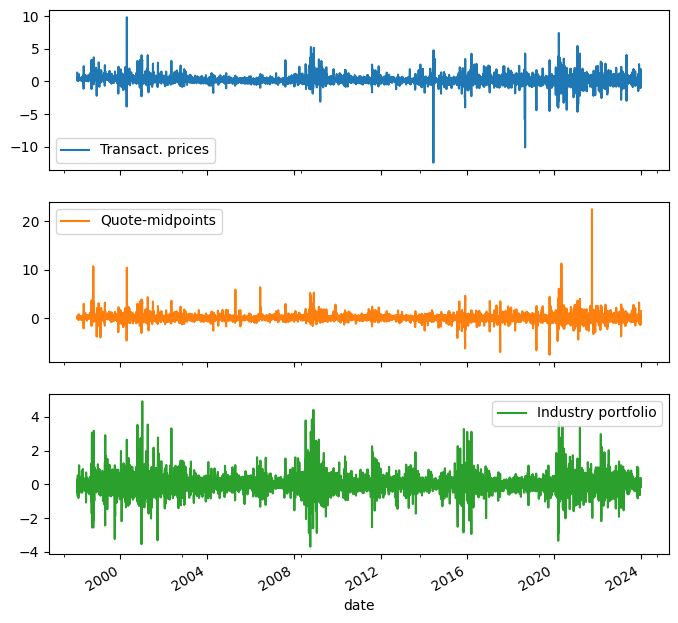

In [27]:
ret_raw_new.plot(subplots=True, figsize=(8, 8));

#### Reproduction of Table 1A

In [28]:
df_stat_A_new = calc_reversal_strategy.summary_stats(ret_raw_new, reproduce=True)
df_stat_A_new


,Transact. prices,Quote-midpoints,Industry portfolio
Mean return(% per day),0.23,0.16,0.01
Std.dev.(% per day),0.67,0.77,0.52
Skewness,-0.51,4.98,0.70
Kurtosis,48.95,136.81,14.53
Worst day return(%),-12.44,-7.49,-3.70
Worst 3-month return(%),-7.54,-9.33,-12.17
Beta,0.12,0.10,0.09
Annualized Sharpe Ratio,5.39,3.27,0.32


#### Panel B. Returns hedged for conditional market

In [29]:
ret_hedged_new = calc_reversal_strategy.load_reversal_return(data_dir=DATA_DIR, hedged=True, reproduce=True)
ret_hedged_new.describe()

,Hedged Transact. prices,Hedged Quote-midpoints,Hedged Industry portfolio
count,6541.000000,6541.000000,6541.000000
mean,0.222346,0.155463,0.006958
std,0.649029,0.760231,0.502595
min,-12.468568,-7.482404,-3.302789
25%,-0.048768,-0.147860,-0.216632
50%,0.184247,0.117841,-0.008990
75%,0.448183,0.408307,0.207582
max,9.570218,22.812476,4.250488


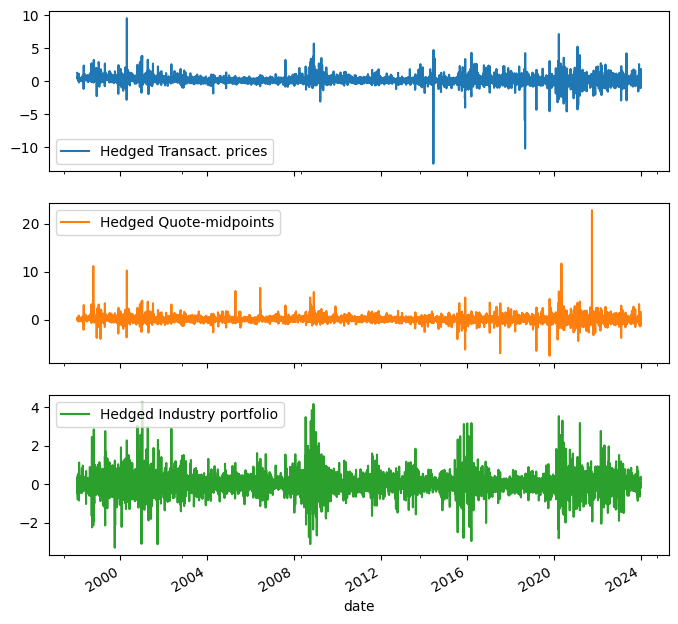

In [30]:
ret_hedged_new.plot(subplots=True, figsize=(8, 8));

#### Reproduction of Table 1B

In [31]:
df_stat_B_new = calc_reversal_strategy.summary_stats(ret_hedged_new, reproduce=True)
df_stat_B_new

,Hedged Transact. prices,Hedged Quote-midpoints,Hedged Industry portfolio
Mean return(% per day),0.22,0.16,0.01
Std.dev.(% per day),0.65,0.76,0.50
Skewness,-0.72,5.40,0.64
Kurtosis,52.57,152.26,12.62
Worst day return(%),-12.47,-7.48,-3.30
Worst 3-month return(%),-5.40,-9.49,-10.05
Beta,0.00,-0.00,-0.00
Annualized Sharpe Ratio,5.44,3.25,0.22


### Table 2: Predicting Reversal Strategy Returns with VIX

#### Table 2 Reproduction

In [32]:
reversal_ret_new = calc_reversal_strategy.load_reversal_return(reproduce=True)
reversal_ret_new.columns = ['trade', 'quote', 'industry']

In [33]:
data_new = regression_hac.prepare_data(reversal_ret_new, vix, rm)
data_m_new = regression_hac.prepare_data(reversal_ret_new, vix, rm, to_monthly=True)


In [34]:
table = regression_hac.generate_table(data_new, data_m_new)
table

\makecell{Individual stocks\\Transaction-price returns}          \
                                                             Daily           
                                                               (1)     (2)   
Intercept                                               -0.08        -0.08   
                                                       (0.02)       (0.03)   
VIX                                                      0.24         0.21   
                                                       (0.02)       (0.02)   
Pre-decim.                                                            0.26   
                                                                    (0.03)   
$R_M$                                                                        
                                                                             
Adj. $R^2$                                               0.04         0.05   

                            \
                   Monthly   
               (3)     (4)   
Intercept    -0.05   -0.01   
            (0.02)  (0.02)   
VIX           0.19    0.15   
            (0.02)  (0.02)   
Pre-decim.    0.27    0.28   
            (0.03)  (0.03)   
$R_M$        -0.39    0.03   
            (0.17)  (0.18)   
Adj. $R^2$    0.05    0.53   

           \makecell{Individual stocks\\Quote-midpoint returns}          \
                                                          Daily           
                                                            (5)     (6)   
Intercept                                               -0.09     -0.09   
                                                       (0.03)    (0.03)   
VIX                                                      0.19      0.18   
                                                       (0.02)    (0.03)   
Pre-decim.                                                         0.09   
                                                                 (0.03)   
$R_M$                                                                     
                                                                          
Adj. $R^2$                                               0.02      0.02   

                           \makecell{Industry\\portfolios}                  \
                   Monthly                           Daily                   
               (7)     (8)                             (9)    (10)    (11)   
Intercept    -0.06   -0.02                           -0.09   -0.09   -0.07   
            (0.03)  (0.03)                          (0.02)  (0.02)  (0.02)   
VIX           0.17    0.12                            0.08    0.08    0.07   
            (0.02)  (0.03)                          (0.02)  (0.02)  (0.02)   
Pre-decim.    0.10    0.12                                    0.00    0.00   
            (0.03)  (0.03)                                  (0.02)  (0.02)   
$R_M$        -0.47   -0.04                                           -0.24   
            (0.23)  (0.26)                                          (0.16)   
Adj. $R^2$    0.02    0.19                            0.01    0.01    0.01   

                    
           Monthly  
              (12)  
Intercept    -0.06  
            (0.02)  
VIX           0.05  
            (0.01)  
Pre-decim.    0.01  
            (0.02)  
$R_M$        -0.03  
            (0.13)  
Adj. $R^2$    0.08

Note: Newey-West HAC standard errors (with 20 lags for daily data and 3 lags for monthly data) are reported in parentheses.

---

## Analysis outside of replication

### 1. Performance of Reversal Strategies

In [35]:
ret_raw = calc_reversal_strategy.load_reversal_return(data_dir=DATA_DIR)

index = pd.read_parquet(DATA_DIR / "pulled" / "CRSP_DSIX.parquet")
index = index.set_index('caldt')['vwretx']*100

strategies = pd.concat([ret_raw, index], axis=1)
strategies.columns = ['Transact. prices','Quote-midpoints','Industry portfolio', 'CRSP Value Weighted Index']

In [36]:
performance_matrix = additional_analysis.performance_summary(strategies, 252)
performance_matrix

,Transact. prices,Quote-midpoints,Industry portfolio,CRSP Value Weighted Index
Annualized Mean Return(%),76.97,47.94,4.02,7.86
Annualzied Volatility(%),8.94,10.57,8.85,19.65
Annualized Sharpe Ratio,8.61,4.53,0.45,0.40
Skewness,3.01,3.57,0.77,-0.27
Kurtosis,38.46,50.15,14.60,12.01
VaR (0.05)(%),-0.33,-0.61,-0.74,-1.92
CVaR (0.05)(%),-0.67,-1.02,-1.22,-2.96
Max Drawdown(%),-4.38,-7.70,-13.90,-57.18
Peak,2000-04-11,2001-07-13,1998-04-09,2007-10-09
Bottom,2000-04-14,2001-09-21,1998-10-08,2009-03-09


Apart from the original statistical analysis of reversal strategy provided by the paper, we create a new version of performance matrix which includes VaR(0.05), CVaR(0.05), max drawdown, and other drawdown-based strategy perfomance, and we also add CRSP value weighted index as the benchmark to evaluate the performance of reversal strategies. 

Compared to the CRSP value weighted index, the reversal strategy based on individual stocks tends to have much higher annualized mean return and lower annualized volatility, which cause a way higher annualized sharpe ratio. The mean return of industry reversal strategy is a little bit lower than the banchmark, but it has lower volatility with higher sharpe ratio.

With regard to max drawdown, the transact price based individual reversal strategy is the best(-4.38%) among all the reversal strategies(quote-midpoints: -7.70%, industry: -13.90%) and the CRSP index(-57.18%). That strategy dropped form the peak on 2009-10-22 after the period of financial crisis. And it only used 7 days to recover the lose since the peak, while the industry reversal strategy took 433 days to recover and CRSP value weighted index didn't recover to the peak.

### 2. Reversal Strategy vs VIX

In [37]:
vix = load_vix.load_vix(data_dir=DATA_DIR)
reversal_strategy = ret_raw.join(vix, how='left')
reversal_strategy['Transact. prices'] = reversal_strategy['Transact. prices'].rolling(window=62).mean()

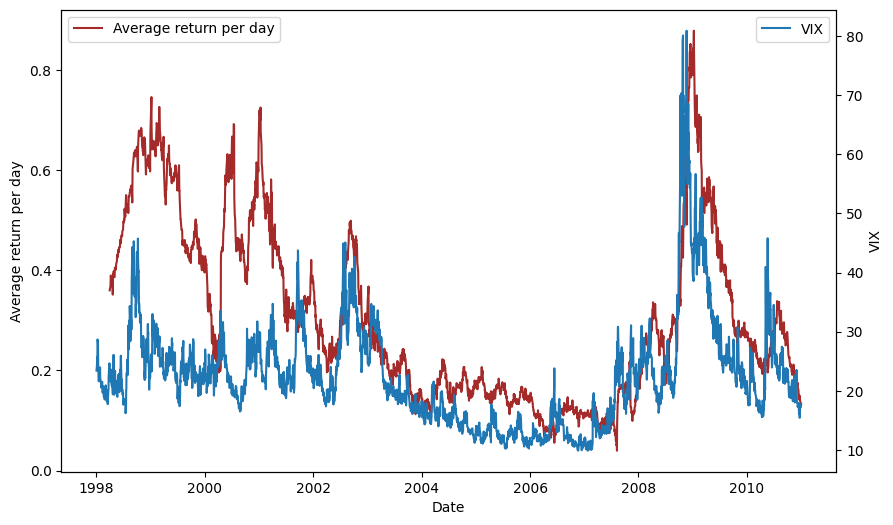

In [38]:
# Plot reversal strategy and VIX
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(reversal_strategy.index, reversal_strategy['Transact. prices'], color='brown')
ax1.set_ylabel('Average return per day')
plt.legend(['Average return per day'])

ax2 = ax1.twinx()
ax2.plot(reversal_strategy.index, reversal_strategy['VIXCLS'])
ax2.set_ylabel('VIX')
plt.legend(['VIX'])

ax1.set_xlabel('Date')
plt.show()

This figure shows the three-month moving average return of the reversal strategy and VIX index across 1998 to 2010. The blue curve(VIX index) has a pre-trend of the red curve(3-month MA return of reversal strategy), which presents a key finding of the paper that the VIX index has a power to predict the reversal strategy return.

During the LTCM crisis in 1998 and  Nasdaq decline in 2000, the reversal strategy return increased with VIX increasing. From then until 2007, returns declined steadily to less than 0.2% per day, but during the financial crisis, they surged, surpassing levels seen during the LTCM crisis. The figure illustrates a strong correlation between the time variation in the reversal strategy's return and the VIX index. Since the financial crisis began in 2007, the returns of the reversal strategy and the VIX have closely tracked each other.
